In [2]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split

In [19]:
clustered_data = pd.read_csv(r"clustered_data/scaled_clustered_data4.csv")

In [5]:
clustered_data


,athlete_id,a_skiba_xpower_mean,a_skiba_xpower_std,a_skiba_relative_intensity_mean,a_skiba_relative_intensity_std,a_skiba_bike_score_mean,a_skiba_bike_score_std,a_skiba_variability_index_mean,a_skiba_variability_index_std,a_skiba_response_index_mean,...,heart.rate_dist_mean,heart.rate_dist_min,heart.rate_dist_bins_mean,speed_dist_mean,cadence_dist_mean,power_mmp_mean,time_in_zone_P2_mean,time_in_zone_P3_mean,skiba_wprime_low_mean,Cluster
0,116767a0-ea53-47db-92ef-be314dbc12c6,202.555023,41.637623,0.700800,0.151689,31.868618,18.492952,1.189736,0.517296,1.532699,...,26.080000,1.0,70.599998,84.671020,341.814178,433.706238,366.656342,299.316132,7.228305,0
1,aa032581-fc55-457d-a4cf-c3e80cdd1749,107.717735,37.758183,0.598432,0.209767,36.411724,28.563694,1.124915,0.086137,0.974693,...,84.529854,1.0,81.194031,128.915470,415.135223,242.547623,364.163330,227.158051,16.440617,0
2,48664864-f400-4eb9-987d-7e593513ba71,233.967941,49.470592,0.749759,0.160123,115.067184,88.813629,1.235608,0.136336,1.681149,...,52.198605,1.0,59.651569,79.380104,1182.659790,770.963623,190.158737,240.955139,9.952229,1
3,54826f98-9163-4d8b-bcf4-f266a4499788,210.994614,63.392723,0.653234,0.196263,55.888615,44.362804,1.165826,0.164747,1.542336,...,36.482456,1.0,55.175438,62.110252,450.841797,489.953491,241.602081,258.581635,13.217029,-1
4,5378edd5-ad24-4b25-ba14-89ae975dd7b1,236.240280,42.533337,0.774558,0.139454,139.244980,83.520416,1.117924,0.091841,1.738858,...,34.934212,1.0,61.973682,86.892685,770.610901,692.255127,160.438782,185.147964,8.213734,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,30774b13-db92-4c3d-8831-9b9382ff6bb0,227.553833,33.401691,0.758513,0.111339,56.584824,38.864574,1.139812,0.121516,1.853232,...,56.515556,1.0,34.311111,43.699734,160.343842,711.136353,84.801651,86.364380,11.956824,-1
606,b327a936-34c7-4fe4-9cfc-92a34005ea47,205.710571,45.322834,0.685703,0.151076,77.831474,42.698250,1.311229,0.230082,1.582421,...,54.119205,1.0,78.587196,428.744420,1252.789917,885.416687,237.068909,188.598694,7.929242,1
607,b8df10d5-da9a-4991-90e5-930838c9599c,175.039612,33.420185,0.717375,0.136968,65.548943,46.699650,1.198224,0.307640,1.187389,...,47.678375,1.0,75.415894,90.230770,517.147705,514.427734,88.857704,97.307083,9.844563,-1
608,9638a911-9e02-4e15-9f3e-9f2277e24dac,235.976913,49.566307,0.829499,0.173155,130.973083,96.559372,1.443641,2.312828,1.818770,...,76.362183,1.0,67.900642,116.779260,811.155579,872.948547,142.621750,169.890167,6.681973,3


Workload Prediction to Normalized Power for Each Cluster

In [5]:
workload_metrics = [
    'time_riding_mean',
    'a_coggan_tssperhour_mean',
    'trimp_points_mean',
    'nonzero_power_mean',
    'percent_in_zone_P5_mean'
]

Create Clustering Model

Random Stratified Sampling Each Rider from each of the clusters. Segment their activities based on date and predict what cluster they fall into. See how often they drift


In [4]:
clustered_data_no_outliers = clustered_data[clustered_data['Cluster'] != -1]
X = clustered_data_no_outliers.drop(columns=['Cluster'])
y = clustered_data_no_outliers['Cluster']


In [7]:
y.value_counts()

Cluster
1    381
3     43
0     25
2     20
4     16
Name: count, dtype: int64

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

def multi_stratified_split(X, y, proportions, random_state=42):
    """
    proportions: list of floats summing to 1, e.g. [0.6, 0.2, 0.1, 0.1]
    returns: dict mapping split index → (X_split, y_split)
    """
    assert np.isclose(sum(proportions), 1.0), "Proportions must sum to 1"
    X_remaining, y_remaining = X, y
    splits = {}
    cum = 0.0

    for i, prop in enumerate(proportions[:-1]):
        # compute relative size for this split against what's left
        rel_size = prop / (1 - cum)
        X_part, X_remaining, y_part, y_remaining = train_test_split(
            X_remaining, y_remaining,
            test_size=1 - rel_size,
            stratify=y_remaining,
            random_state=random_state
        )
        splits[i] = (X_part, y_part)
        cum += prop

    # last split gets whatever remains
    splits[len(proportions)-1] = (X_remaining, y_remaining)
    return splits

# Usage:
props = [0.6, 0.2, 0.1, 0.1]  # Train, Val, Test, Hold-out
splits = multi_stratified_split(X, y, props)

X_train, y_train   = splits[0]
X_val,   y_val     = splits[1]
X_test,  y_test    = splits[2]
X_hold,  y_hold    = splits[3]


In [9]:
print("a_friel_efficiency_factor_mean" in clustered_data.columns)

True


In [13]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from opendata import OpenData

od = OpenData()

def safe_float(val):
    if isinstance(val, list):
        val = val[0]
    try:
        return float(val)
    except Exception:
        return np.nan

def get_feature_df(athlete_id, feature_key, date_key='date'):
    """
    (unchanged) Build a time‐series DataFrame for ONE athlete and ONE metric.
    """
    records = []
    athlete = od.get_local_athlete(athlete_id)
    aid_raw = athlete.metadata.get('ATHLETE', {}).get('id', '')
    athlete_id = aid_raw.strip('{}')
    
    for activity in athlete.activities():
        meta    = activity.metadata or {}
        metrics = meta.get('METRICS', {})
        if feature_key not in metrics:
            continue

        date_str = meta.get(date_key)
        if not date_str:
            continue

        try:
            dt = pd.to_datetime(date_str)
        except Exception:
            dt = pd.to_datetime(date_str, format='%Y/%m/%d %H:%M:%S UTC')

        val = safe_float(metrics[feature_key])
        records.append({'date': dt, feature_key: val, 'athlete_id': athlete_id})

    if not records:
        return pd.DataFrame(columns=[feature_key, 'athlete_id']) \
                 .set_index(pd.DatetimeIndex([], name='date'))

    df = pd.DataFrame(records)
    return df.set_index('date').sort_index()

def adaptation_rate_timeseries(
        df,
        perf_col="20m_critical_power_mean",
        load_col="a_skiba_bike_score_mean",
        date_col="date",
        athlete_col="athlete_id",
        window_perf=14,          # <- more tolerant
        window_load=42):         # <- matches CTL
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    rows = []
    for aid, g in df.groupby(athlete_col):
        g = g.sort_values(date_col).copy()

        # rolling perf & load
        g["perf_roll"]  = g[perf_col].rolling(window_perf, min_periods=4).mean()
        g["load_roll"]  = g[load_col].rolling(window_load).sum()

        # forward-looking delta
        g["delta_perf"] = g["perf_roll"].shift(-1) / g["perf_roll"] - 1

        # align: use current 42-day load to predict next-window delta
        reg = g.dropna(subset=["delta_perf", "load_roll"])
        if len(reg) < 3:
            slope = np.nan
        else:
            reg["load_z"] = (reg["load_roll"] - reg["load_roll"].mean()) / reg["load_roll"].std()
            slope = ols("delta_perf ~ load_z", data=reg).fit().params["load_z"]

        rows.append({"athlete_id": aid, "adapt_rate": slope})

    return pd.DataFrame(rows)


def compute_and_merge_adaptation_rate(
    original_df: pd.DataFrame,
    athlete_id_col: str = 'athlete_id',
    perf_key: str = '20m_critical_power',
    load_key: str = 'a_skiba_bike_score',
    date_key: str = 'date',
    window_perf: int = 7,
    window_load: int = 28
) -> pd.DataFrame:
    """
    For each athlete in `original_df`, fetch perf & load time series,
    compute their adaptation rate, and return only those athletes
    with a valid adapt_rate (dropping all others).

    If `athlete_id_col` isn’t in the columns, this will treat the
    DataFrame’s index as the athlete‐ID.
    """
    # 1. bring athlete_id into a column if it's currently the index
    df = original_df.copy()
    if athlete_id_col not in df.columns:
        idx_name = df.index.name or 'index'
        df = df.reset_index().rename(columns={idx_name: athlete_id_col})

    # 2. fetch and merge each athlete's perf+load series
    combined = []
    for aid in df[athlete_id_col].unique():
        print(aid)
        perf_df = get_feature_df(aid, perf_key, date_key)
        load_df = get_feature_df(aid, load_key, date_key)
        print(f"Athlete {aid!r}: perf rows = {len(perf_df)}, load rows = {len(load_df)}")
        if perf_df.empty or load_df.empty:
            continue

        merged = (
            perf_df[[perf_key]]
            .join(load_df[[load_key]], how='inner')
            .reset_index()
            .assign(**{athlete_id_col: aid})
        )
        combined.append(merged)

    # 3. compute adapt_rate if we got any data
    if combined:
        all_acts = pd.concat(combined, ignore_index=True)
        adap_df = adaptation_rate_timeseries(
            all_acts,
            perf_col=perf_key,
            load_col=load_key,
            date_col=date_key,
            athlete_col=athlete_id_col,
            window_perf=window_perf,
            window_load=window_load
        )
    else:
        return original_df.iloc[0:0]

    # 4. inner‐join back, then restore athlete_id as index if that’s how you started
    result = df.merge(
        adap_df[[athlete_id_col, 'adapt_rate']],
        how='inner',
        on=athlete_id_col
    )

    # if original_df used the index for athlete_id, put it back
    if athlete_id_col not in original_df.columns:
        result = result.set_index(athlete_id_col)

    return result


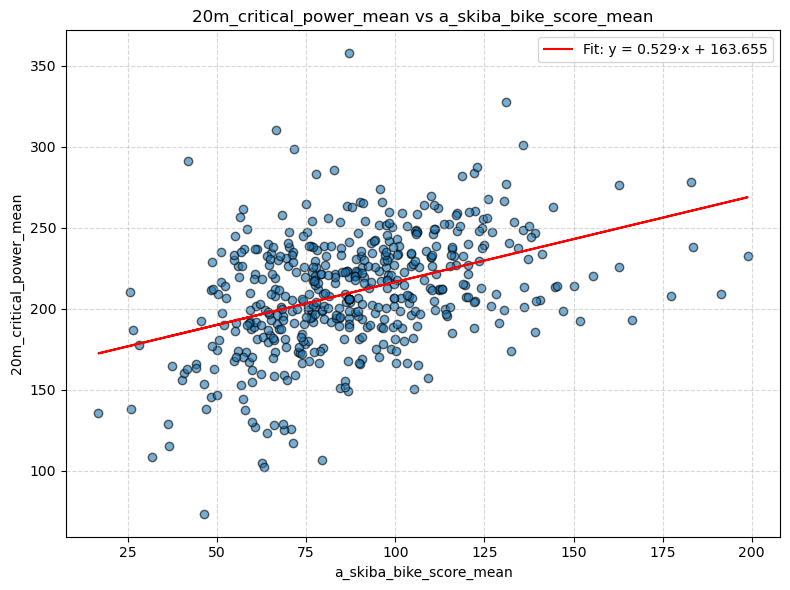

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_perf_vs_load_matplotlib(df, perf_col, load_col,
                                 figsize=(8,6), alpha=0.6):
    """
    Scatter of perf_col vs load_col with 1st‐degree poly fit.
    """
    x = df[load_col].astype(float)
    y = df[perf_col].astype(float)

    # compute line of best fit
    m, b = np.polyfit(x, y, 1)

    plt.figure(figsize=figsize)
    plt.scatter(x, y, alpha=alpha, edgecolor='k')
    plt.plot(x, m*x + b, color='red',
             label=f'Fit: y = {m:.3f}·x + {b:.3f}')
    plt.xlabel(load_col)
    plt.ylabel(perf_col)
    plt.title(f"{perf_col} vs {load_col}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_perf_vs_load_matplotlib(
    df=clustered_data,
    perf_col='20m_critical_power_mean',
    load_col='a_skiba_bike_score_mean'
)

In [15]:
adapt_rate_slopes = compute_and_merge_adaptation_rate(clustered_data)

116767a0-ea53-47db-92ef-be314dbc12c6
Athlete '116767a0-ea53-47db-92ef-be314dbc12c6': perf rows = 147, load rows = 139
aa032581-fc55-457d-a4cf-c3e80cdd1749
Athlete 'aa032581-fc55-457d-a4cf-c3e80cdd1749': perf rows = 40, load rows = 42
48664864-f400-4eb9-987d-7e593513ba71
Athlete '48664864-f400-4eb9-987d-7e593513ba71': perf rows = 349, load rows = 385
e7079a4a-e6d5-4dfe-a0c9-48c7789cfd96


KeyboardInterrupt: 

In [16]:
adapt_rate_slopes    

,athlete_id,a_skiba_xpower_mean,a_skiba_xpower_std,a_skiba_relative_intensity_mean,a_skiba_relative_intensity_std,a_skiba_bike_score_mean,a_skiba_bike_score_std,a_skiba_variability_index_mean,a_skiba_variability_index_std,a_skiba_response_index_mean,...,heart.rate_dist_min,heart.rate_dist_bins_mean,speed_dist_mean,cadence_dist_mean,power_mmp_mean,time_in_zone_P2_mean,time_in_zone_P3_mean,skiba_wprime_low_mean,Cluster,adapt_rate
0,116767a0-ea53-47db-92ef-be314dbc12c6,0.158110,0.260983,-0.080994,0.319653,-1.477644,-1.710210,0.033356,1.183544,0.222299,...,0.0,0.125712,-0.144848,-0.502552,-0.601388,1.661169,1.180418,-0.926341,0,-0.010989
1,aa032581-fc55-457d-a4cf-c3e80cdd1749,-2.184934,-0.003299,-1.076120,1.549622,-1.355127,-1.319306,-0.449397,-0.412905,-1.474722,...,0.0,0.555318,0.082495,-0.377213,-1.426640,1.642611,0.575959,0.713652,0,0.032632
2,48664864-f400-4eb9-987d-7e593513ba71,0.934195,0.794594,0.394942,0.498249,0.766043,1.019341,0.374983,-0.227034,0.673767,...,0.0,-0.318265,-0.172035,0.934836,0.854589,0.347294,0.691535,-0.441423,1,-0.000132
3,e7079a4a-e6d5-4dfe-a0c9-48c7789cfd96,-0.142128,-0.237465,-0.321653,-0.311752,0.690971,0.324533,0.339338,0.035362,-0.356755,...,0.0,-1.374953,-0.242465,0.521093,0.739978,0.371261,0.549406,0.163983,1,-0.003526
4,da778a76-ddc6-4954-b62d-2e8d37ec747f,0.440400,-0.486779,-0.155335,-0.756486,0.631967,-0.042192,-0.243480,-0.358144,0.165429,...,0.0,-0.823064,-0.279664,0.586611,0.804962,-0.630289,-0.733016,1.495155,1,-0.002945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,95b4575b-51b4-4f7c-bdcc-0341d48ae406,1.339245,1.291432,-0.808461,-0.045652,0.979433,0.815323,0.631523,1.278838,1.228930,...,0.0,-0.952359,-0.010811,0.871333,1.091904,-0.460814,-0.303047,0.153180,1,-0.004349
347,4c06e8da-29df-4c9e-bb77-53c26dd83aa8,0.157086,-0.827691,-0.741491,-1.194819,0.633651,-0.596880,0.138972,-0.411961,0.102761,...,0.0,-2.365919,-0.502385,0.471873,-0.129605,0.720635,1.679033,-0.037054,4,-0.003501
348,b327a936-34c7-4fe4-9cfc-92a34005ea47,0.236070,0.512033,-0.227754,0.306656,-0.238125,-0.770663,0.938162,0.120082,0.373514,...,0.0,0.449606,1.623118,1.054721,1.348695,0.696500,0.252952,-0.801559,1,NaN
349,9638a911-9e02-4e15-9f3e-9f2277e24dac,0.983828,0.801115,1.170103,0.774241,1.194991,1.319998,1.924291,7.831847,1.092304,...,0.0,0.016249,0.020135,0.299766,1.294869,-0.006579,0.096233,-1.023600,3,-0.003409


In [34]:
adapt_rate_slopes.to_csv('adapt_rate_slopes.csv', index=True)

In [16]:
import pandas as pd 
df_adapt_rate_slopes = pd.read_csv('adapt_rate_slopes.csv',index_col=0)

In [ ]:
adapt_rate_slopes

,a_skiba_xpower_mean,a_skiba_xpower_std,a_skiba_relative_intensity_mean,a_skiba_relative_intensity_std,a_skiba_bike_score_mean,a_skiba_bike_score_std,a_skiba_variability_index_mean,a_skiba_variability_index_std,a_skiba_response_index_mean,a_skiba_response_index_std,...,heart.rate_dist_min,heart.rate_dist_bins_mean,speed_dist_mean,cadence_dist_mean,power_mmp_mean,time_in_zone_P2_mean,time_in_zone_P3_mean,skiba_wprime_low_mean,Cluster,adapt_rate
athlete_id,,,,,,,,,,,,,,,,,,,,,
aa032581-fc55-457d-a4cf-c3e80cdd1749,-2.220471,0.000707,-1.087656,1.593955,-1.406311,-1.408476,-0.506098,-0.454483,-1.544743,0.842535,...,0.0,0.614778,0.192864,-0.361532,-1.466271,1.896881,0.594685,0.816345,0,0.032632
48664864-f400-4eb9-987d-7e593513ba71,0.945840,0.837445,0.401371,0.523788,0.783583,1.056189,0.426957,-0.206855,0.705758,-0.084027,...,0.0,-0.265336,-0.080457,0.938594,0.855302,0.401053,0.714019,-0.502727,1,-0.000132
54826f98-9163-4d8b-bcf4-f266a4499788,0.369677,1.832047,-0.548409,1.302840,-0.864043,-0.762177,-0.161247,-0.066703,0.263554,1.012324,...,0.0,-0.448208,-0.175746,-0.301047,-0.379304,0.843285,0.866475,0.160998,2,0.001701
5378edd5-ad24-4b25-ba14-89ae975dd7b1,1.002829,0.341846,0.645395,0.078241,1.456731,0.839657,-0.565020,-0.426343,0.889597,-0.610772,...,0.0,-0.170467,-0.039005,0.240616,0.509500,0.145566,0.231330,-0.856159,1,-0.003715
d332123e-c7d9-40a1-802e-406232349aed,-0.637579,0.073888,-0.252279,0.416171,-0.718588,-0.365674,-0.650013,-0.230484,-0.726600,0.563794,...,0.0,0.672310,-0.122597,-0.956064,-0.595747,1.078203,0.850904,0.647536,0,-0.004396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4c06e8da-29df-4c9e-bb77-53c26dd83aa8,0.156976,-0.863819,-0.748939,-1.199543,0.646901,-0.647123,0.159833,-0.453225,0.107640,-0.725533,...,0.0,-2.328301,-0.435195,0.479839,-0.146298,0.832187,1.733624,-0.040946,1,-0.003501
5528444e-779b-425d-a0b4-25e4bca2f4f6,-0.236097,-0.989020,0.094951,-0.945996,-0.630575,-0.569550,-0.227652,0.265271,-0.332815,-1.310025,...,0.0,0.283155,-0.309794,0.000492,-1.013138,-0.402114,-0.426615,0.848617,1,-0.002056
30774b13-db92-4c3d-8831-9b9382ff6bb0,0.784976,-0.310522,0.487509,-0.527807,-0.844660,-0.987095,-0.380521,-0.279959,1.253950,-0.230043,...,0.0,-1.300618,-0.277330,-0.793128,0.592454,-0.504647,-0.623073,-0.095198,1,-0.000113


In [54]:
df_adapt_rate_slopes.sort_values(by="a_skiba_bike_score_mean", ascending=False, inplace=False)

,a_skiba_xpower_mean,a_skiba_xpower_std,a_skiba_relative_intensity_mean,a_skiba_relative_intensity_std,a_skiba_bike_score_mean,a_skiba_bike_score_std,a_skiba_variability_index_mean,a_skiba_variability_index_std,a_skiba_response_index_mean,a_skiba_response_index_std,...,heart.rate_dist_min,heart.rate_dist_bins_mean,speed_dist_mean,cadence_dist_mean,power_mmp_mean,time_in_zone_P2_mean,time_in_zone_P3_mean,skiba_wprime_low_mean,Cluster,adapt_rate
athlete_id,,,,,,,,,,,,,,,,,,,,,
66325c2e-4879-45fa-a755-a0dbd395bf68,0.173546,-0.141242,-0.312124,-0.357545,3.115660,1.210285,0.117892,-0.427281,1.996264,0.210962,...,0.0,-0.589646,-0.356172,1.789055,0.106120,0.511556,0.658211,-0.625902,1,-0.000004
f78e4e2c-8454-4f00-b565-4abf9a4999af,-0.311013,-0.548119,-0.018099,-0.434309,2.909335,1.755027,0.237901,-0.161102,0.048598,-0.266508,...,0.0,-0.280231,0.142096,1.362286,-0.224673,1.630181,2.134936,-0.260146,1,-0.000002
0845e82d-fa5f-487f-83f5-2fb00c6c0cc9,0.801827,-0.001342,2.006679,0.325368,2.691101,2.685704,0.656538,0.241384,1.056580,-0.119059,...,0.0,0.170975,1.327536,0.887303,0.371667,0.399999,0.499124,-2.438630,1,-0.000005
9206a6b0-f76b-4d35-b414-1f85ce124b54,0.860910,-1.817531,2.099406,-1.866739,2.670159,-0.071354,0.469441,-0.550408,0.569577,-1.131468,...,0.0,0.309025,0.505631,0.690446,0.738303,1.319849,1.671864,-5.135909,1,NaN
66980d09-8f5a-42b5-873f-96905c2853eb,-0.005404,0.266600,2.546662,1.618644,2.516281,1.792372,-0.455511,-0.371240,-0.433174,0.275782,...,0.0,0.800779,1.004622,-0.183188,0.945701,-0.559451,-0.920629,-2.304338,1,-0.000037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8f54f0ed-fbef-4c53-90ab-85c8919d1613,-0.753692,1.411441,-1.217657,1.436932,-1.635039,-1.110521,-1.043922,-0.442816,-0.860681,1.130495,...,0.0,0.071405,0.667343,0.179354,-0.824303,0.115287,-0.078177,0.808760,1,0.000012
ac4ec125-80f7-4a26-8867-fe7c470c8832,-0.628467,-0.582517,-0.292521,-0.401206,-1.685532,-1.357211,-1.290972,-0.546362,0.000000,0.000000,...,0.0,-0.105703,-0.463930,-1.044711,-1.355150,-0.939940,-1.152061,1.096542,1,-0.000006
d0135273-6bad-4a89-8fd0-797e1e3c3c6e,-1.745229,-2.696748,-1.990575,-2.927882,-1.702365,-2.576941,-1.488219,-0.879388,-1.910526,-2.323157,...,0.0,0.110835,-0.304898,-0.207371,-1.398382,-0.283490,-0.199994,1.538332,1,NaN


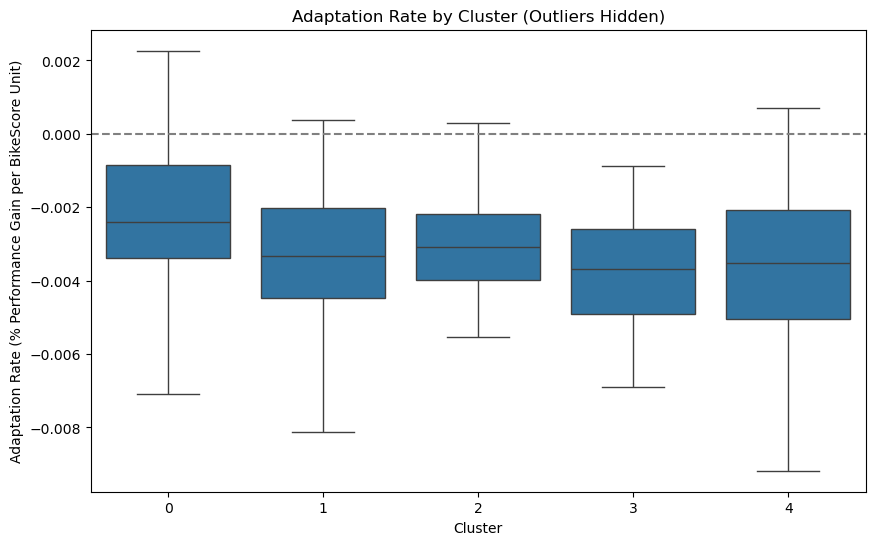

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up figure
plt.figure(figsize=(10, 6))

# Make a boxplot, but hide outliers with "showfliers=False"
sns.boxplot(
    x="Cluster",
    y="adapt_rate",
    data=adapt_rate_slopes,
    showfliers=False,   # <- Hides outliers
)

# Add a horizontal reference line at 0 (no adaptation)
plt.axhline(0, linestyle='--', color='gray')

# Titles and labels
plt.title("Adaptation Rate by Cluster (Outliers Hidden)")
plt.xlabel("Cluster")
plt.ylabel("Adaptation Rate (% Performance Gain per BikeScore Unit)")

# Display plot
plt.show()


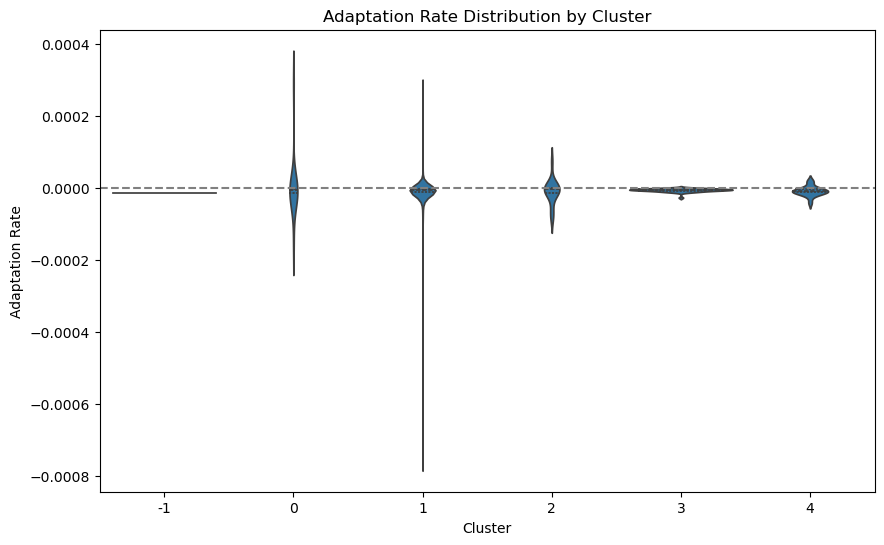

In [59]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Cluster", y="adapt_rate", data=df_adapt_rate_slopes, inner="quartile")
plt.axhline(0, linestyle='--', color='gray')
plt.title("Adaptation Rate Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Adaptation Rate")
plt.show()


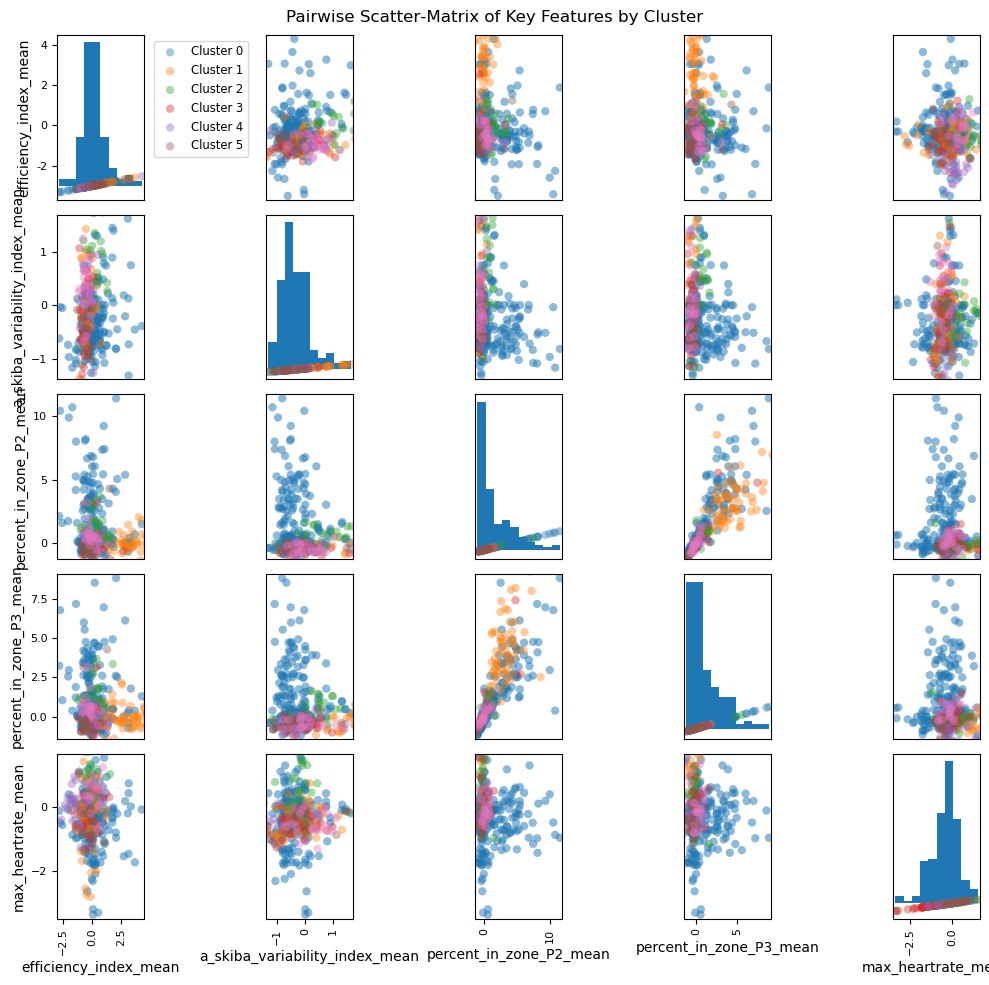

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# 1. Load and filter
clustered_data = clustered_data[clustered_data['Cluster'] >= 0]  # drop noise/outliers

# 2. Select a handful of key features + cluster for color‐coding
features = [
    'efficiency_index_mean',
    'a_skiba_variability_index_mean',
    'percent_in_zone_P2_mean',
    'percent_in_zone_P3_mean',
    'max_heartrate_mean'
]
plot_df = clustered_data[features + ['Cluster']]

# 3. Create the scatter‐matrix
scatter_matrix(
    plot_df[features],
    figsize=(10, 10),
    diagonal='hist',
    marker='o',
    alpha=0.5
)

# 4. Overlay cluster coloring
#   (this is a bit manual with scatter_matrix, but illustrative)
axes = plt.gcf().axes
for i, xi in enumerate(features):
    for j, yi in enumerate(features):
        ax = axes[i * len(features) + j]
        for cl in sorted(plot_df['Cluster'].unique()):
            subset = plot_df[plot_df['Cluster'] == cl]
            ax.scatter(
                subset[xi],
                subset[yi],
                label=f'Cluster {cl}',
                alpha=0.4,
                edgecolors='none'
            )
        if i == 0 and j == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.suptitle("Pairwise Scatter‐Matrix of Key Features by Cluster")
plt.tight_layout()
plt.show()


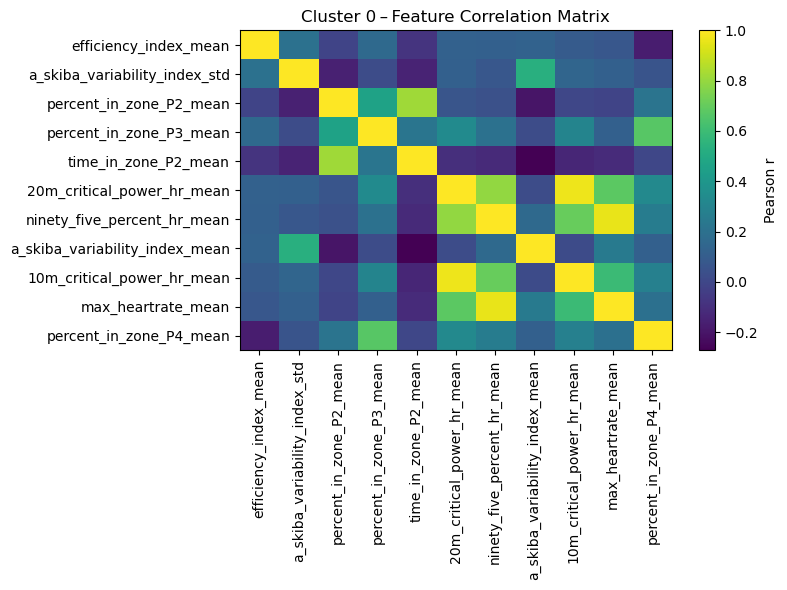

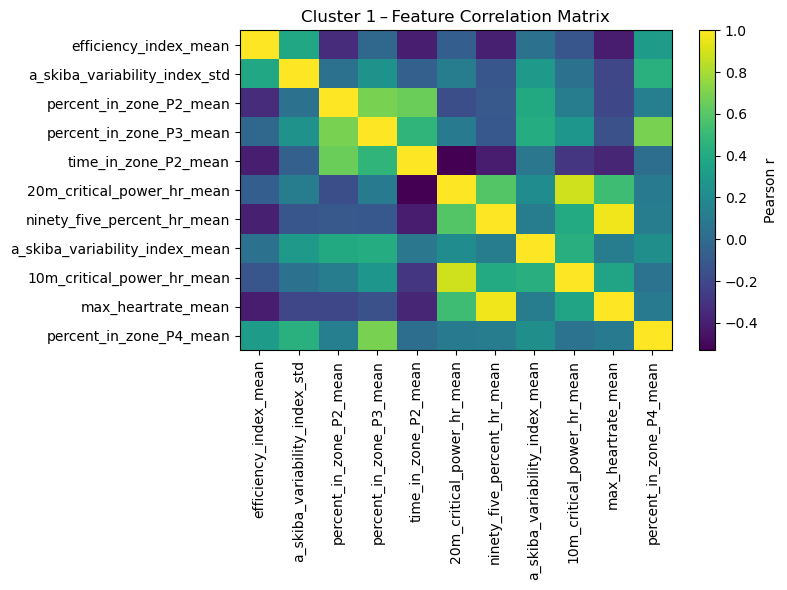

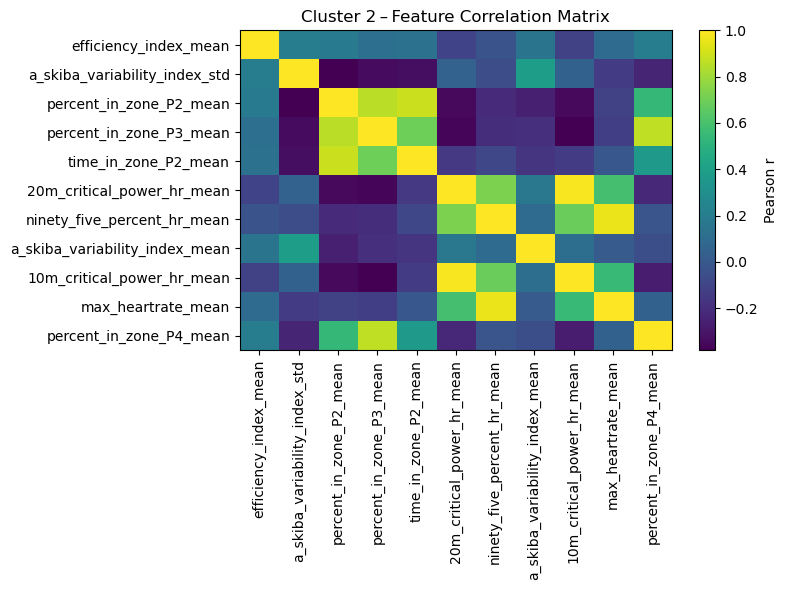

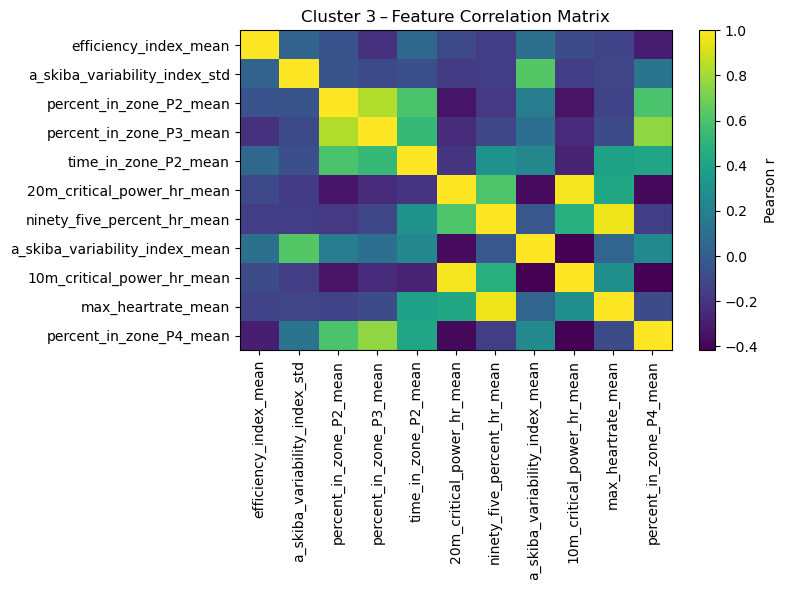

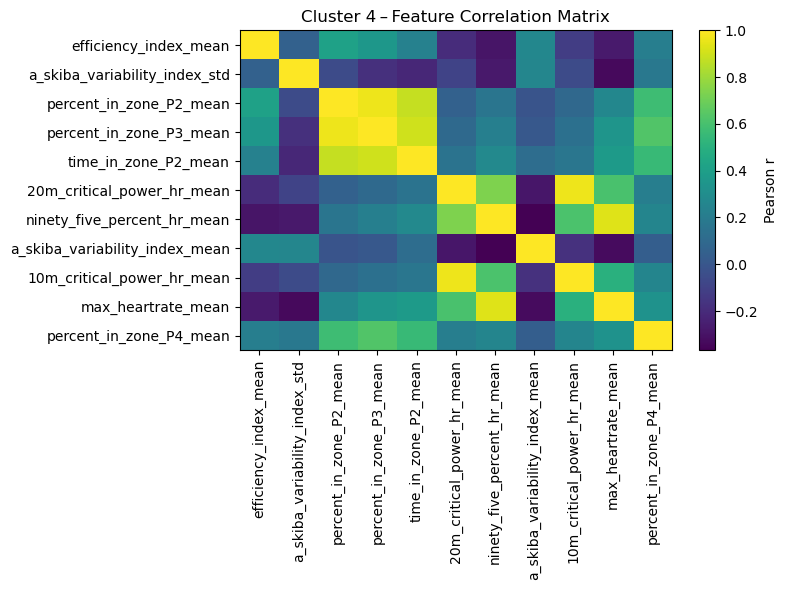

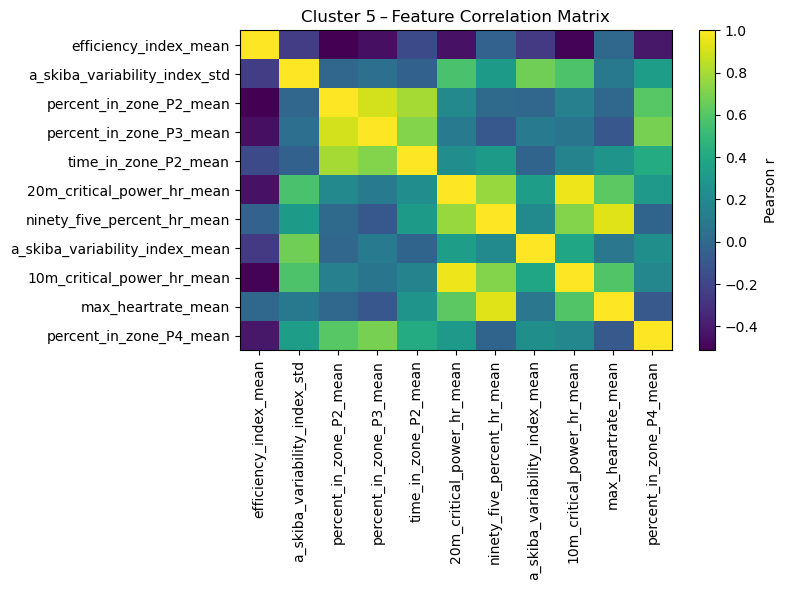

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load and filter


# 2. Define the features you care about
features =['efficiency_index_mean',
 'a_skiba_variability_index_std',
 'percent_in_zone_P2_mean',
 'percent_in_zone_P3_mean',
 'time_in_zone_P2_mean',
 '20m_critical_power_hr_mean',
 'ninety_five_percent_hr_mean',
 'a_skiba_variability_index_mean',
 '10m_critical_power_hr_mean',
 'max_heartrate_mean',
 'percent_in_zone_P4_mean']
# 3. Loop through clusters and plot
for cl in sorted(clustered_data['Cluster'].unique()):
    subset = clustered_data[clustered_data['Cluster'] == cl][features]
    corr = subset.corr()

    plt.figure(figsize=(8, 6))
    plt.imshow(corr, aspect='auto', interpolation='none')
    plt.colorbar(label='Pearson r')
    plt.xticks(np.arange(len(features)), features, rotation=90)
    plt.yticks(np.arange(len(features)), features)
    plt.title(f'Cluster {cl} – Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
